# Basic setup for fetching data from the facebook api

### Remember to add an active access token below and adjust the parameters and fields if necessary

In [216]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
# import packages
import numpy as np
import pandas as pd
from political_ads.api_request import get_json_response
from political_ads.helper import *

# insert your access token here (expires every 2 hours)
access_token = "EAAHmCGvnrWoBAGF0nGZBMWcAWQLHaBkU44Rb45UR96oteiVeAwSPgoNYUSxdh58wHOZCQkB7q5AzUZA0GyzvvOi5LZCgOOkZBXBbLAHIU5eDHzfZCMsTHwdMZCKZCP83Ad1238TX8OFqwoh4x2ASC4sgRSRbL5He7y735vECdIsJzQMgnoTN81zwb7CadEt150yqgKxZC8oQ30HdNZCGiu02tr"

# PARAMETERS NECESSARY
ad_type = "POLITICAL_AND_ISSUE_ADS"
ad_reached_countries = ['US'] # Facebook delivered the ads in these countries. Provided as ISO country codes.
search_terms = "climate change" # The terms to search for in your query. We treat a blank space as a logical AND and search for both terms and no other operators. The limit of your string is 100 characters or less.
limit = 500

# FIELDS to specify your results
fields = ["ad_creation_time", "ad_creative_body","spend", "impressions", "delivery_by_region", "demographic_distribution","page_id", "page_name","bylines","id"]

# see here for more parameters and fields: https://www.facebook.com/ads/library/api/?source=archive-landing-page 

input_url = f"https://graph.facebook.com/v12.0/ads_archive?search_terms={search_terms}&ad_type={ad_type}&ad_reached_countries={ad_reached_countries}&fields={fields}&limit={limit}"

response = get_json_response(input_url, access_token)

data = pd.DataFrame(response["data"])


In [156]:
'''
Data Generation
Loop to continuously fetch data, until there exists a next page
'''
import time

counter = 0
while "next" in response["paging"]:
    if counter == 50:
        break
    response = get_json_response(response["paging"]["next"], access_token)
    new_data = pd.DataFrame(response["data"])
    data = data.append(new_data, ignore_index=True)
    counter += 1
    time.sleep(10)
    print(f"Iteration number {counter}")

# Could go up to 70.000 entries
# Reached iteration 140

Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Iteration number 6
Iteration number 7
Iteration number 8
Iteration number 9
Iteration number 10
Iteration number 11
Iteration number 12
Iteration number 13
Iteration number 14
Iteration number 15
Iteration number 16
Iteration number 17
Iteration number 18
Iteration number 19
Iteration number 20
Iteration number 21
Iteration number 22


KeyboardInterrupt: 

In [157]:
# Save data as csv
data.to_csv("..\\data\\exported_df.csv", index=False, header=True)

In [217]:
# Read csv
data = pd.read_csv("..\\data\\exported_df.csv")

In [218]:

def string_to_dict(dict_string):
    import json 
    # Convert to proper json format
    dict_string = dict_string.replace("'", '"')
    return json.loads(dict_string)

diction = string_to_dict(data["impressions"][0])
diction["lower_bound"]

'1000'

In [219]:
# Apply transformations to dataset
data["spend"] = data["spend"].apply(lambda x: string_to_dict(x))
data["impressions"] = data["impressions"].apply(lambda x: string_to_dict(x))

{'lower_bound': '0', 'upper_bound': '99'}

In [214]:
# def transform_range(entry: dict):
#     return int(int(entry["lower_bound"]) + int(entry["upper_bound"])) / 2

In [220]:
# Apply transformations to dataset
data["spend"] = data["spend"].apply(lambda x: transform_range(x))
data["impressions"] = data["impressions"].apply(lambda x: transform_range(x))

In [221]:
data.head()

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id
0,2021-08-27,🌎 Sierra Club's City Hike-A-Thon is a national...,49.5,1499.5,"[{'percentage': '0.789011', 'region': 'Massach...","[{'percentage': '0.006508', 'age': '45-54', 'g...",6204742571,Sierra Club,SIERRA CLUB,161524832762330
1,2021-08-27,🌎 Sierra Club's City Hike-A-Thon is a national...,49.5,1499.5,"[{'percentage': '0.001553', 'region': 'Connect...","[{'percentage': '0.00155', 'age': '18-24', 'ge...",6204742571,Sierra Club,SIERRA CLUB,317427000179234
2,2021-08-27,🌎 Sierra Club's City Hike-A-Thon is a national...,49.5,1499.5,"[{'percentage': '0.003442', 'region': 'Connect...","[{'percentage': '0.001724', 'age': '35-44', 'g...",6204742571,Sierra Club,SIERRA CLUB,1033393710740228
3,2021-08-27,🌎 Sierra Club's City Hike-A-Thon is a national...,549.5,27499.5,"[{'percentage': '0.002533', 'region': 'Connect...","[{'percentage': '0.004997', 'age': '35-44', 'g...",6204742571,Sierra Club,SIERRA CLUB,6504918652853309
4,2021-08-27,🌎 Sierra Club's City Hike-A-Thon is a national...,149.5,9499.5,"[{'percentage': '1', 'region': 'California'}]","[{'percentage': '0.009098', 'age': '18-24', 'g...",6204742571,Sierra Club,SIERRA CLUB,144479121120381


In [222]:
# Convert date to datetime timestamp object
data["ad_creation_time"] = pd.to_datetime(data["ad_creation_time"])
data["ad_creation_time"]

0       2021-08-27
1       2021-08-27
2       2021-08-27
3       2021-08-27
4       2021-08-27
           ...    
11995   2021-07-19
11996   2021-07-19
11997   2021-07-19
11998   2021-07-19
11999   2021-07-19
Name: ad_creation_time, Length: 12000, dtype: datetime64[ns]

<AxesSubplot:xlabel='ad_creation_time'>

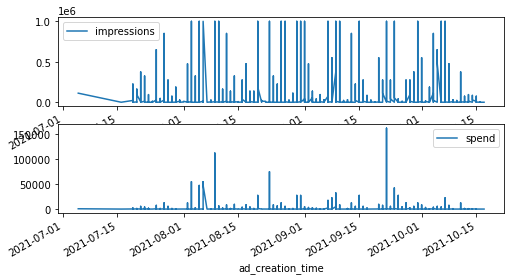

In [223]:
'''
Visualization attempts
https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
'''
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting spending over time and impressions over time 
fig, axes = plt.subplots(2,1,figsize=(8,4))
data.plot(x="ad_creation_time", y="impressions", ax=axes[0])
data.plot(x="ad_creation_time", y="spend", ax=axes[1])

In [239]:
'''
Amount spend by facebook page
'''
by_page = data.groupby("page_name").agg(
    # Aggregate no of ads
    no_ads = ('id', 'count'),
    # Aggregate sum of spend
    sum_spend = ('spend', 'sum'),
    # Average number of impressions per ad
    avg_impressions = ('impressions', 'mean')

).reset_index()

by_page[by_page["page_name"] == "Sierra Club"]


,page_name,no_ads,sum_spend,avg_impressions
955,Sierra Club,49,29925.5,61928.071429


In [66]:
'''
Data Generation
Loop to continuously fetch data, until there exists a next page
'''
import time

counter = 0
while "next" in response["paging"]:
    response = get_json_response(response["paging"]["next"], access_token)
    new_data = pd.DataFrame(response["data"])
    data = data.append(new_data, ignore_index=True)
    counter += 1
    time.sleep(10)
    print(f"Iteration number {counter}")

# Could go up to 70.000 entries
# Reached iteration 140

KeyboardInterrupt: 

In [ ]:
data.to_csv("..\\data\\exported_df.csv", index=False, header=True)

In [ ]:
'''
Read data sample
'''
sample = pd.read_csv("..\\data\\exported_df.csv")

sample